# A simple data science workflow for processed LC-MS metabolomics data

In this second notebook, we will be using R to do some basic data analysis tasks for our processed data, including QC filtering, normalization, univariate analysis, and visualization of top features.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shuzhao-li-lab/2025_Chapter_DataScience/blob/main/notebooks/02_R_for_metabolomics_data_science.ipynb)


## Notebook setup

The R runtime environment in Google Colab includes several commonly used packages pre-installed. However, for data science and bioinformatic tasks, we will need to install some additional packages for specific tasks.

R packages generally come from two major sources:

- **CRAN**: Repository for general-purpose R packages
- **Bioconductor**: Bioinformatics-focused repository

Be aware that installing R packages in Colab can take several minutes, as many dependencies need to be fetched and compiled. It can take around 5-10 minutes depending on your connection.

In [ ]:
# 1 - setup

install.packages(c("tune", "janitor", "countdata", "viridis"))

library(tidyverse)
library(httr)
library(jsonlite)
library(readr)
library(RColorBrewer)
library(tune)
library(janitor)
library(countdata)
library(viridis)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘DiceDesign’, ‘sfd’, ‘future.apply’, ‘globals’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘sparsevctrs’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘modelenv’, ‘dials’, ‘doFuture’, ‘foreach’, ‘future’, ‘GPfit’, ‘hardhat’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘workflows’, ‘yardstick’, ‘snakecase’, ‘gridExtra’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-l

### Data download

Next, let's download the feature table file we need to do the analysis. This is a standard output from preprocessing pipelines such as XCMS, MS-DIAL, and pcpfm (asari).

1.   **Feature table** -  A dataframe with samples in columns and feature intensities in rows.

The dataset consists of six Escherichia coli (E. coli) samples: three grown with natural-abundance C-12 and three grown with uniformly labeled C-13.

In [ ]:
# 2 - data download

# use the GitHub url to read in feature table
git_url = "https://raw.githubusercontent.com/shuzhao-li-lab/khipu/refs/heads/main/testdata/ecoli_pos.tsv"

feat_tbl <- readr::read_tsv(git_url)

head(feat_tbl)

Rows: 3602 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): id_number
dbl (8): mz, rtime, 12C_Ecoli_20220321_004, 12C_Ecoli_20220321_004_202203220...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id_number,mz,rtime,12C_Ecoli_20220321_004,12C_Ecoli_20220321_004_20220322095030,12C_Ecoli_20220321_004_20220322130235,13C_Ecoli_20220321_004,13C_Ecoli_20220321_004_20220322132355,13C_Ecoli_20220321_004_20220322101150
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,61.9278,40.94,42543,0,0,43369,60144,57714
F2,95.9735,125.06,2079328,984349,1314348,1707804,1299125,1159692
F3,115.9802,11.42,3362695,3228128,4076328,3201740,3942341,3326312
F4,115.9860,5.83,2035714,1739145,1978764,1977817,2040421,1642861
F5,115.9860,27.96,182603,219669,248607,199092,185630,185255
F6,65.0260,127.33,514697,1040139,684393,538232,685752,605475


Now that the data has been downloaded from the GitHub repo and read, let's format it so we can work with it properly. In this case we will:

1 - transpose the feature table so samples are in rows and features in columns;

2 - remove the feature information to clean up the table;

3 - remove features with 0 variance (not informative);

4 - make a metadata table with the sample names and adding a group label (12C, 13C).

In [ ]:
# 3 - data formatting

feat_tbl_clean <- feat_tbl %>%
  select(-c(mz, rtime)) %>%
  t() %>%
  as.data.frame() %>%
  janitor::row_to_names(row_number = 1) %>%
  mutate(across(everything(), as.numeric))

# remove features with 0 variance
# not informative anyways
feat_tbl_clean_no_var <- feat_tbl_clean %>%
  select(where(~ sd(., na.rm = TRUE) != 0))

# make metadata
meta_data <- data.frame(samples = rownames(feat_tbl_clean_no_var),
                        group = gsub("_.*", "", rownames(feat_tbl_clean_no_var)))

cat(glue::glue("{ncol(feat_tbl_clean) - ncol(feat_tbl_clean_no_var)} features were removed due to 0 variance."))

meta_data[1:5, ]
feat_tbl_clean[1:5, 1:5]

8 features were removed due to 0 variance.

,samples,group
,<chr>,<chr>
1,12C_Ecoli_20220321_004,12C
2,12C_Ecoli_20220321_004_20220322095030,12C
3,12C_Ecoli_20220321_004_20220322130235,12C
4,13C_Ecoli_20220321_004,13C
5,13C_Ecoli_20220321_004_20220322132355,13C


,F1,F2,F3,F4,F5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12C_Ecoli_20220321_004,42543,2079328,3362695,2035714,182603
12C_Ecoli_20220321_004_20220322095030,0,984349,3228128,1739145,219669
12C_Ecoli_20220321_004_20220322130235,0,1314348,4076328,1978764,248607
13C_Ecoli_20220321_004,43369,1707804,3201740,1977817,199092
13C_Ecoli_20220321_004_20220322132355,60144,1299125,3942341,2040421,185630


### Global visualization

First, we will plot a PCA using the raw intensities for all samples. We are looking for any extreme outliers, observing how samples cluster together, and how much variance is explained by the first two PCs.

Warning message in brewer.pal(n = length(levels(pca_res$group)), name = "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


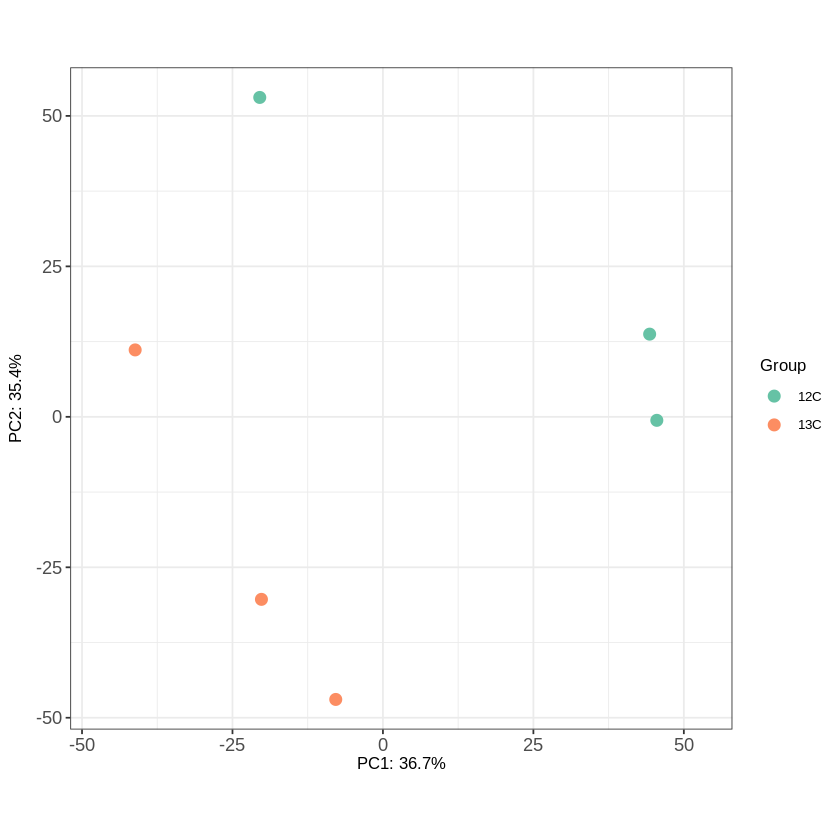

In [ ]:
# 4 - PCA
# below is a R function that will be used several times
# it plots a PCA given a feature and metadata table

plot_pca <- function(feat_tbl_clean,
                     meta_data){

  # samples in rows
  # features in columns
  pc <- stats::prcomp(na.omit(feat_tbl_clean),
                      center = TRUE,
                      scale = TRUE)

  ### Plot the PCA

  pc$percentVar <- pc$sdev^2/sum(pc$sdev^2)

  pca_res <- as.data.frame(pc$x)
  pca_res$group <- as.factor(meta_data$group)

  colors <- setNames(brewer.pal(n = length(levels(pca_res$group)), name = "Set2"),
                     levels(pca_res$group))

  p <- ggplot2::ggplot(data = pca_res,
                       ggplot2::aes(x = PC1,
                                    y = PC2,
                                    color = group)) +
    ggplot2::geom_jitter(size = 3) +
    ggplot2::theme_bw() +
    ggplot2::scale_color_manual(values = colors) +
    ggplot2::labs(x = glue::glue("PC1: ", round(pc$percentVar[1]*100,1), "%"),
                  y = glue::glue("PC2: ", round(pc$percentVar[2]*100,1), "%")) +
    ggplot2::theme(text = ggplot2::element_text(size = 10),
                   axis.text = ggplot2::element_text(size = 11)) +
    ggplot2::guides(color = ggplot2::guide_legend(title = "Group")) +
    tune::coord_obs_pred()

  return(p)

}

# now plot the raw data
p <- plot_pca(feat_tbl_clean_no_var, meta_data)

p

In the PCA, samples are colored by their group label. The first two PCs explains ~70% of variance in the dataset, suggesting there are clear metabolic differences between our two groups. This is not unexpected as the 13C samples are grown in a medium of 13-C, so the mass spectra of labeled metabolites will show mass shifts (+1 Da per 13-C).

### Data filtering and normalization

We will now perform several next steps to ensure high-quality data for downstream analysis:

**1 - Filter features with missing values:** Features with excessive missing values may results from low abundance metabolites,  inconsistent detection, or technical artifacts. Including all features can compromise statistical power, so we keep just consistently detected features, focusing on robust signals.

**2 - Replace zeros with LoD:** In many cases, an intensity of zero likely represents signals below the limit of detection (LoD), rather than a true absence. To avoid zero-inflated data, let's replace zeros with an estimated LoD: the minimum positive intensity value for feature, divided by five.

**3 - Filter features with high variability:** We will use RSD (Relative Standard Deviation), which is the standard deviation of a feature divided by its mean, as a measure of variability. Features with high RSD across technical replicates or QC samples are unreliable and may reflect technical noise rather than true biological signal. Removing these features will improve reproducibility and reduce the likelihood of false positives in subsequent data analysis.

**4 - Data normalization:** This final step corrects for unwanted variation in signal intensity due to technical differences. This helps to reduce heteroscedasticity and makes features more comparable across samples. Common normalization methods include auto-scaling, pareto scaling, and log transformation.

In [ ]:
# 5 - missing value filtering + zero replacements

### Missing value filtering
# remove features with >= 50% missing values
missing_filtered <- feat_tbl_clean_no_var[, colMeans(is.na(feat_tbl_clean_no_var)) <= 0.5]

cat(glue::glue("{ncol(feat_tbl_clean_no_var) - ncol(missing_filtered)} features were removed due to missing values."))

# no features in the end with missing, but let's check 0 counts
num_cols_with_zeros <- sum(sapply(missing_filtered, function(col) any(col == 0, na.rm = TRUE)))

# >1700 with 0s! it's likely that zeros actually represent signals below detection, so
# let's replace them with the limit of detection per feature
# here calculated as the min positive feature intensity divided by 10

### Replace 0s with LoD

cat(glue::glue("{num_cols_with_zeros} features with LoD replacement."))

# Replace zeros with LOD in each feature using lapply
lod_imputed_list <- lapply(missing_filtered, function(x) {

  # Calculate the feature-specific LOD (minimum non-zero value)
  lod <- min(x[x > 0], na.rm = TRUE)/10

  # Replace zeros (or <=0) with the LOD
  x[x <= 0] <- lod

  return(x)
})

# Convert list back to dataframe with same column names
lod_imputed_df <- as.data.frame(lod_imputed_list)

# Keep original column names
colnames(lod_imputed_df) <- colnames(missing_filtered)


0 features were removed due to missing values.1762 features with LoD replacement.

In [ ]:
# 6 - compute RSD in each group per feature
# set up table for filtering
anal_df <- dplyr::bind_cols(group = meta_data$group,
                            lod_imputed_df) %>%
  mutate(group = factor(group))

features <- colnames(lod_imputed_df)

rsd_table <- anal_df %>%
  group_by(group) %>%
  summarise(across(all_of(features), ~ 100 * sd(., na.rm = TRUE) / mean(., na.rm = TRUE)))

# get the min rsd, use this for thresholding
min_rsd <- rsd_table %>%
  select(-group) %>%
  summarise(across(everything(), \(x) min(x, na.rm = TRUE))) %>%
  pivot_longer(everything(), names_to = "feature", values_to = "min_rsd")

rsd_thresh <- 30

# filter to keep features with RSD below threshold
rsd_filtered <- lod_imputed_df[, min_rsd$min_rsd < rsd_thresh]

cat(glue::glue("{ncol(lod_imputed_df) - ncol(rsd_filtered)} features were removed due to high RSD."))

982 features were removed due to high RSD.

Now that we've filtered the data, let's check if our data follows a normal distribution. If not, let's get it there.

Distribution of filtered data has a left skew!

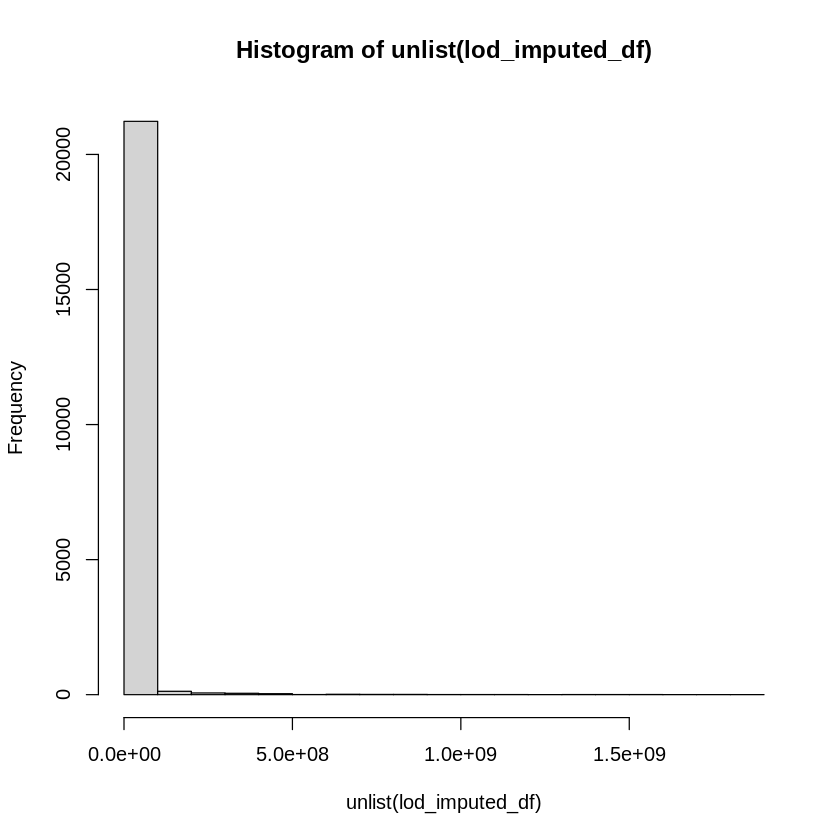

Distribution of normalized data looks Gaussian!

Warning message in brewer.pal(n = length(levels(pca_res$group)), name = "Set2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


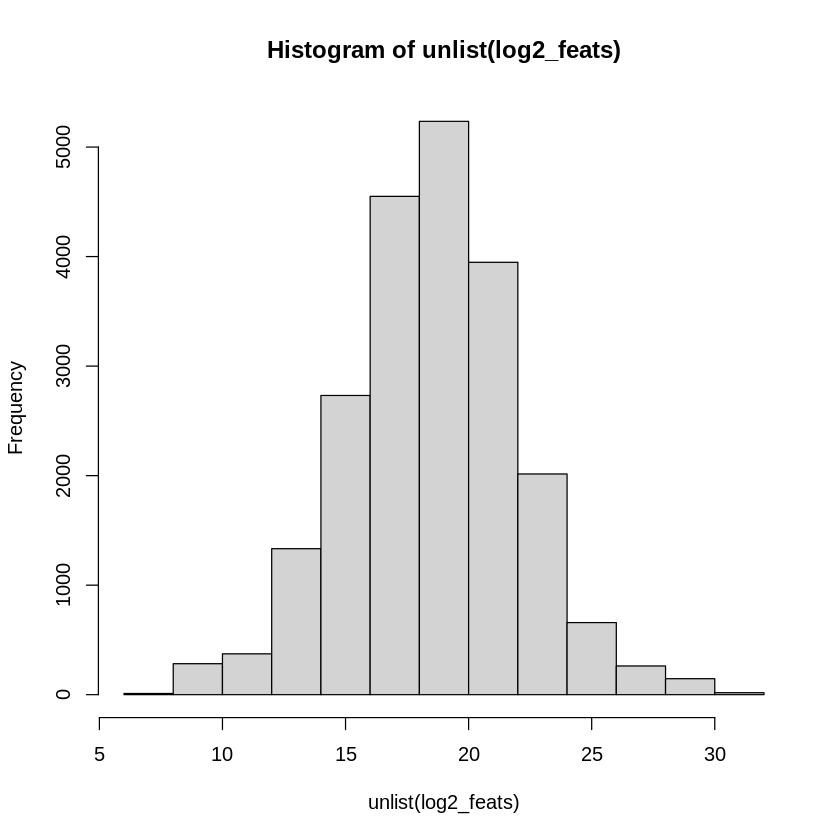

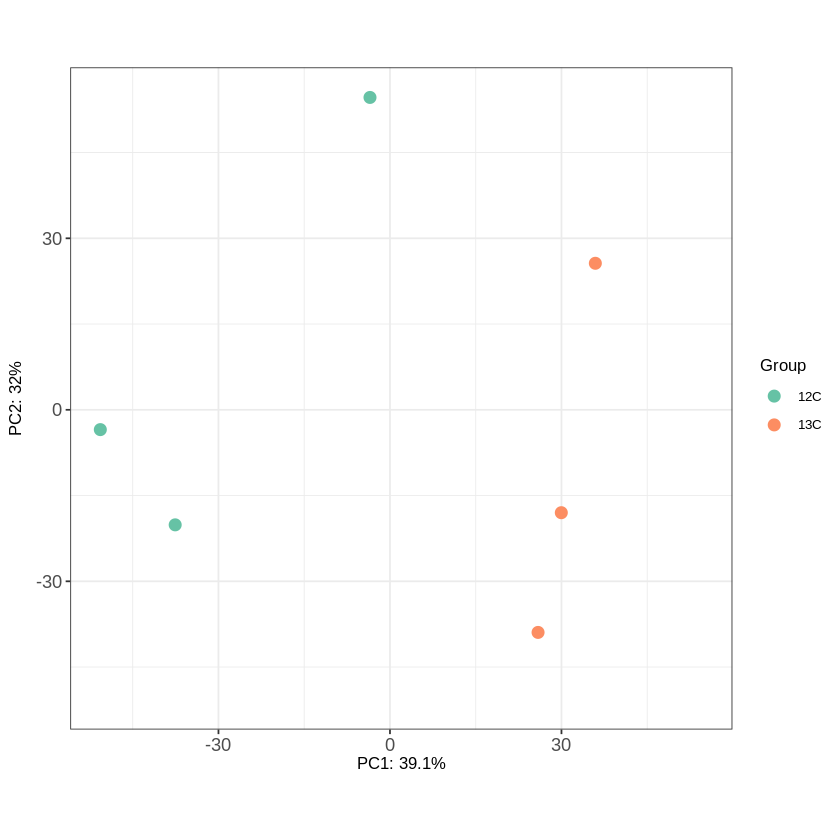

In [ ]:
# 7 - Normalization

# we see a intense left skew, lets try log2 norm
hist(unlist(lod_imputed_df))
cat("Distribution of filtered data has a left skew!")

# Log2 normalize
# distribution of intensities is improved (Gaussian shape)
log2_feats <- log2(lod_imputed_df)
hist(unlist(log2_feats))
cat("Distribution of normalized data looks Gaussian!")

final_ft_tbl <- dplyr::bind_cols(group = meta_data$group,
                                 log2_feats) %>%
  mutate(group = factor(group))

# final visualization, looks good! let's move on to stats
p_clean <- plot_pca(log2_feats, meta_data)

p_clean

Our initial visual assessment focuses on the distribution of our feature intensities. In the first histogram (of filtered raw intensity data), we observe a left-skewed distribution, which tells us the data is not normally distributed. This is problematic as many statistical tests assume data normality (e.g. t-tests, ANOVA), and skewed data violates these assumptions and may lead to inaccurate results.

To address this issue, we applied a log2 transformation to the intensity data, visually evaluated the distribution with a second histogram. From this plot, we observe a Gaussian-like distribution centered in the middle of the x-axis, suggesting the log transformation has effectively normalized the data.

Finally, a PCA on the normalized data shows clear separation between groups. Additionally, the first two PCs explain ~70% of the total variance. Remember that our initial PCA of raw feature intensities also showed group separation. Together, these results suggests that group differences is driven by true biological variation, rather than technical variability or highly variable features.

Let's perform some statistical tests to formally assess group differences.

### Statistical Analysis

Now that the data is ready, we will perform univariate analysis to identify metabolic features that are significantly different across our experimental groups. Each feature will be tested individually to determine whether its intensity varies by group.

In this case, we are using *group* as the categorical variable, which has two levels, so we will use first **T-Tests**. A t-test is designed to compare the means of a continuous variable (ie metabolic feature intensity) across two groups.

- **Null hypothesis (H0):** Group mean intensities are the same.
- **Alternative hypothesis (H1):** One group's mean intensity differs from the other.

In [ ]:
# 8 - Statistical Analysis

# T-test per metabolite

features <- colnames(log2_feats)

tt_models <- lapply(features, function(x) {

  res <- stats::aov(as.formula(paste(x, " ~ group")), data = final_ft_tbl)

} )

tt_pvals <- sapply(tt_models, function(x) unlist(summary(x))["Pr(>F)1"])
tt_pvals_adj <- p.adjust(tt_pvals, "BH")

tt_res <- data.frame(feature = features,
                     p.value = tt_pvals,
                     adj.p.value = tt_pvals_adj) %>%
  arrange(p.value)

head(tt_res)

n_sig <- tt_res %>%
  dplyr::filter(adj.p.value <= 0.05) %>%
  count()

cat(glue::glue("{n_sig} features with an adjusted-pvalue <= 0.05"))


,feature,p.value,adj.p.value
,<chr>,<dbl>,<dbl>
1,F223,8.688877e-12,3.122782e-08
2,F3335,4.993840e-11,8.973930e-08
3,F3543,3.897797e-10,4.669561e-07
4,F3413,8.389480e-10,7.537948e-07
5,F401,8.171853e-09,4.217277e-06
6,F3224,1.051252e-08,4.217277e-06


808 features with an adjusted-pvalue <= 0.05

In our case, 416 features are significantly different from each other (adjusted p-value < 0.05).

### Fold-Change

Next, let's look at **fold-changes** (FC). Fold-changes are a fundamental analysis in 'omics as it provides an easy-to-use measure of the magnitude of difference between groups. A FC of 1 is no difference, FC > 1 means the feature is up-regulated, and a FC < 1 means a feature is down-regulated.

In [ ]:
# 9 - Fold-change

g1inx <- which(meta_data$group == levels(final_ft_tbl$group)[1])
g2inx <- which(meta_data$group == levels(final_ft_tbl$group)[2])

fc_res <- lapply(features, function(x){

  feats_g1 <- final_ft_tbl[g1inx, which(colnames(final_ft_tbl) == x), drop = FALSE] %>% unlist()
  feats_g2 <- final_ft_tbl[g2inx, which(colnames(final_ft_tbl) == x), drop = FALSE] %>% unlist()

  mean_g1 <- mean(feats_g1, na.rm = TRUE)
  mean_g2 <- mean(feats_g2, na.rm = TRUE)
  fold_change <- mean_g2 / mean_g1
  log2fc <- log2(fold_change)

  res <- data.frame(feature = x,
                    fc = fold_change,
                    log2fc = log2fc)

  res

})

fc_res <- fc_res %>%
  bind_rows() %>%
  arrange(-abs(log2fc))

head(fc_res)

n_sig <- fc_res %>%
  dplyr::filter(abs(log2fc) > 1) %>%
  count()

cat(glue::glue("{n_sig} features with an abs(log2fc) > 0"))

,feature,fc,log2fc
,<chr>,<dbl>,<dbl>
1,F1427,2.4528598,1.2944648
2,F2210,2.1735781,1.1200720
3,F202,2.0542610,1.0386195
4,F1499,2.0132419,1.0095205
5,F945,0.5002173,-0.9993730
6,F495,1.9694272,0.9777761


4 features with an abs(log2fc) > 0

Alone, a FC shows the magnitude of differences between groups, but not confidence. Let's pair the p-values from the t-test and the FCs to build volcano plots. From here, we can see which features are both statistically significant and substantially changing.

Joining with `by = join_by(feature)`


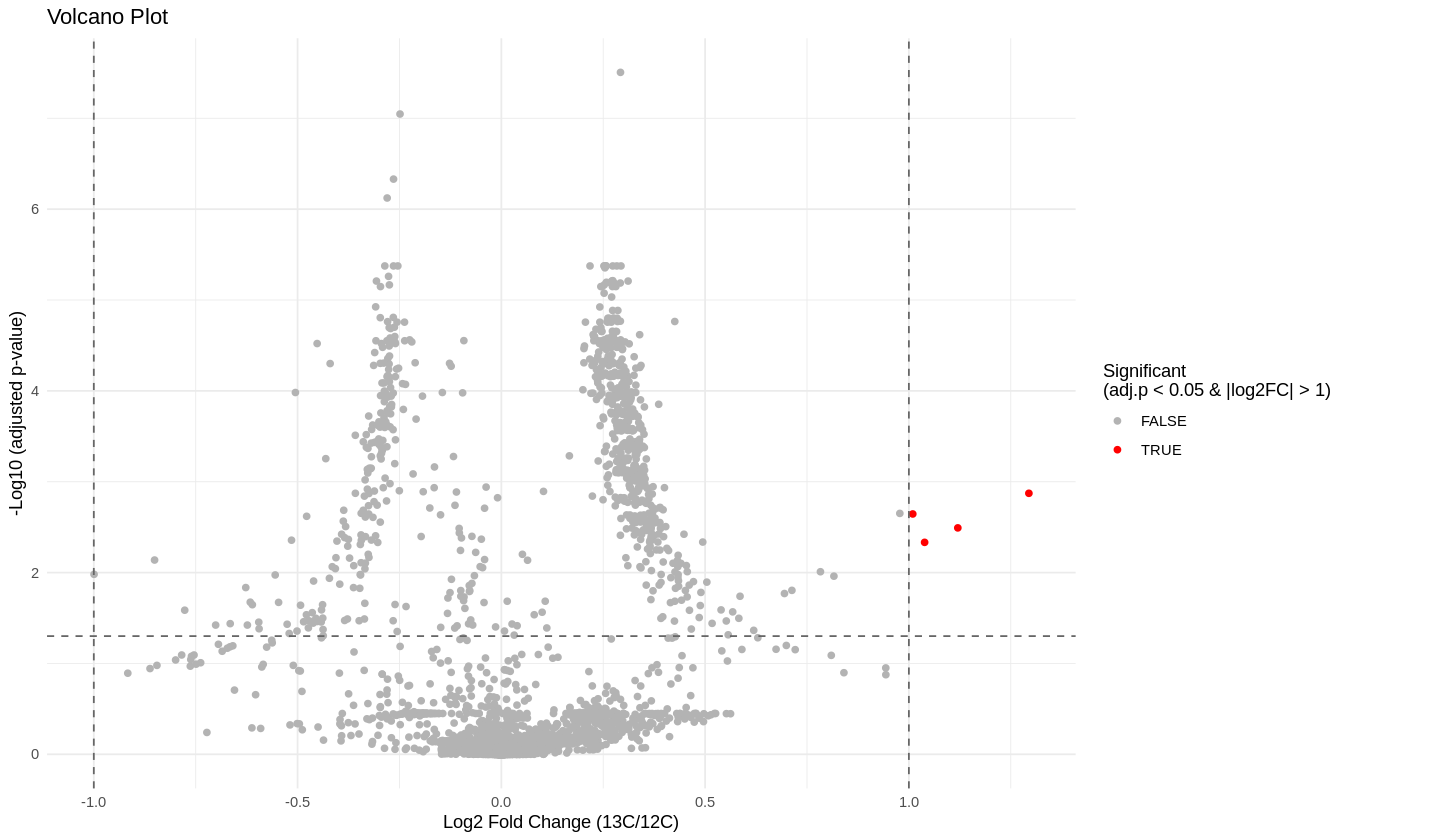

In [ ]:
# 10 - Volcano

options(repr.plot.width = 12, repr.plot.height = 7)

volcano_df <- dplyr::left_join(tt_res, fc_res)

p <- ggplot(volcano_df,
            aes(x = log2fc, y = -log10(adj.p.value))) +
  geom_point(aes(color = adj.p.value < 0.05 & abs(log2fc) > 1)) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "grey40") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey40") +
  labs(
    title = "Volcano Plot",
    x = "Log2 Fold Change (13C/12C)",
    y = "-Log10 (adjusted p-value)",
    color = "Significant\n(adj.p < 0.05 & |log2FC| > 1)"
  ) +
  theme_minimal() +
  scale_color_manual(values = c("FALSE"="grey70", "TRUE"="red"))

p

From the volcano plot, we see there are 4 features with an adjusted p-value < 0.05 and a log2FC >= 1. Let's make one final plot, a violin plot, to show the distribution of the feature intensities across the groups. 

Since the data here are heavily filtered, the plot looks differently from that in the Python notebook. 

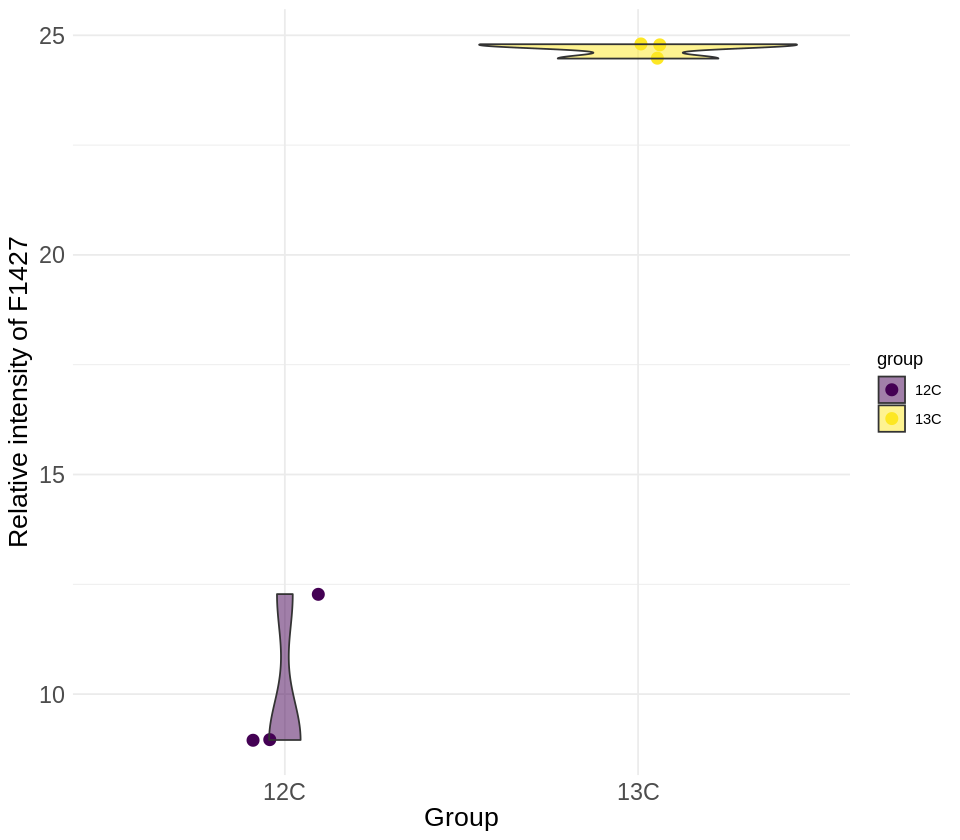

In [ ]:
# 11 - Violin plot

# set figure
options(repr.plot.width = 8, repr.plot.height = 7)

top_feat <- volcano_df %>%
  dplyr::filter(adj.p.value <= 0.05 & abs(log2fc) > 1) %>%
  slice_head(n = 1)

top_feat_int <- final_ft_tbl %>%
  select(group, top_feat$feature)

p_feat <- ggplot(top_feat_int,
                 aes(x = group,
                     y = .data[[top_feat$feature]])) +
  geom_jitter(aes(color = group),
              size = 3,
              width = 0.1) +
  geom_violin(aes(fill = group),
              alpha = 0.5) +
  viridis::scale_color_viridis(discrete = TRUE,
                               option = "D") +
  viridis::scale_fill_viridis(discrete = TRUE,
                              option = "D") +
  theme_minimal() +
  xlab("Group") +
  ylab(glue::glue("Relative intensity of {top_feat$feature}")) +
  theme(axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

p_feat

The violin plot clearly shows that F1427 is significantly up-regulated in 13C labeled *E.coli*.

Congratulations! You have just completed a full metabolomic data analysis workflow - you are now on your way to becoming a data science pro.